In [20]:
import gcsfs
import os
import pandas as pd
import netCDF4 as nc
import tempfile
import h3
import numpy as np
from dask.distributed import Client

### Let's take a look at the output parquets

In [9]:
import os
import pandas as pd

# Specify the directory where your parquet files are stored
parquet_directory = 'data/processed'

# List all parquet files in the directory
parquet_files = [os.path.join(parquet_directory, f) for f in os.listdir(parquet_directory) if f.endswith('.parquet')]

# Read all parquet files and concatenate them into a single DataFrame
df = pd.concat([pd.read_parquet(file) for file in parquet_files])

### One week of hourly precipitation data is captured in 26,397,480 H3 hexagons, using 800 MB of storage.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26397480 entries, 0 to 162068
Data columns (total 3 columns):
 #   Column         Dtype  
---  ------         -----  
 0   h3_index       int64  
 1   precipitation  float64
 2   timestamp      object 
dtypes: float64(1), int64(1), object(1)
memory usage: 805.6+ MB


In [11]:
df.head(10)

h3_index  precipitation            timestamp
0  594482907523842047       0.106609  2022-01-01T00:00:00
1  594483311250767871       0.114773  2022-01-01T00:00:00
2  594483311250767871       0.121496  2022-01-01T00:00:00
3  594483276891029503       0.127739  2022-01-01T00:00:00
4  594483276891029503       0.133982  2022-01-01T00:00:00
5  594483276891029503       0.132541  2022-01-01T00:00:00
6  594483276891029503       0.126778  2022-01-01T00:00:00
7  594483276891029503       0.120535  2022-01-01T00:00:00
8  594483276891029503       0.115253  2022-01-01T00:00:00
9  594483276891029503       0.112852  2022-01-01T00:00:00

In [12]:
df['timestamp'].unique()

array(['2022-01-01T00:00:00', '2022-01-01T01:00:00',
       '2022-01-01T02:00:00', '2022-01-01T03:00:00',
       '2022-01-01T04:00:00', '2022-01-01T05:00:00',
       '2022-01-01T06:00:00', '2022-01-01T07:00:00',
       '2022-01-01T08:00:00', '2022-01-01T09:00:00',
       '2022-01-01T10:00:00', '2022-01-01T11:00:00',
       '2022-01-01T12:00:00', '2022-01-01T13:00:00',
       '2022-01-01T14:00:00', '2022-01-01T15:00:00',
       '2022-01-01T16:00:00', '2022-01-01T17:00:00',
       '2022-01-01T18:00:00', '2022-01-01T19:00:00',
       '2022-01-01T20:00:00', '2022-01-01T21:00:00',
       '2022-01-01T22:00:00', '2022-01-01T23:00:00',
       '2022-01-02T00:00:00', '2022-01-02T01:00:00',
       '2022-01-02T02:00:00', '2022-01-02T03:00:00',
       '2022-01-02T04:00:00', '2022-01-02T05:00:00',
       '2022-01-02T06:00:00', '2022-01-02T07:00:00',
       '2022-01-02T08:00:00', '2022-01-02T09:00:00',
       '2022-01-02T10:00:00', '2022-01-02T11:00:00',
       '2022-01-02T12:00:00', '2022-01-02T13:0

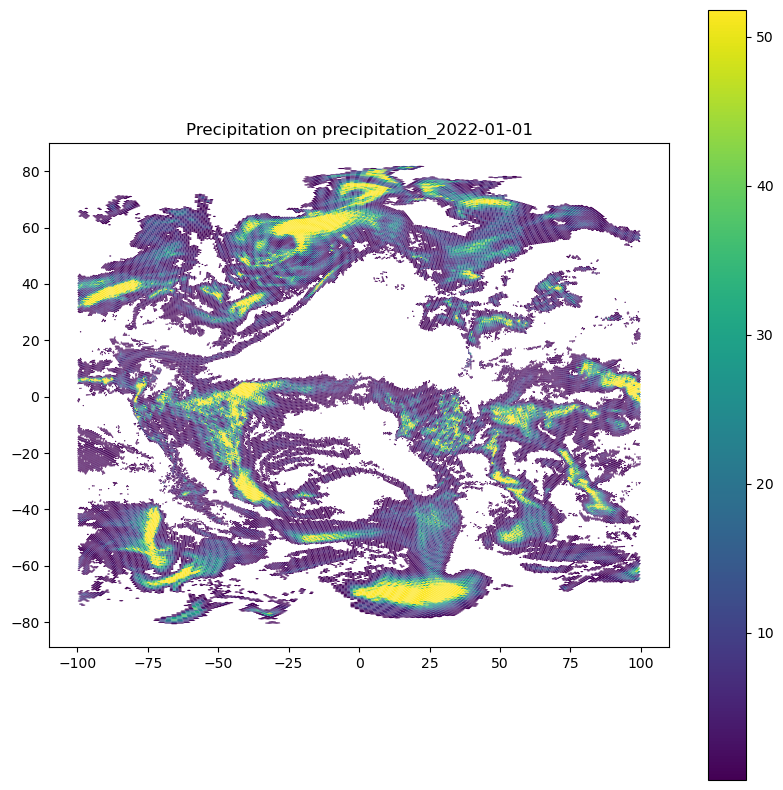

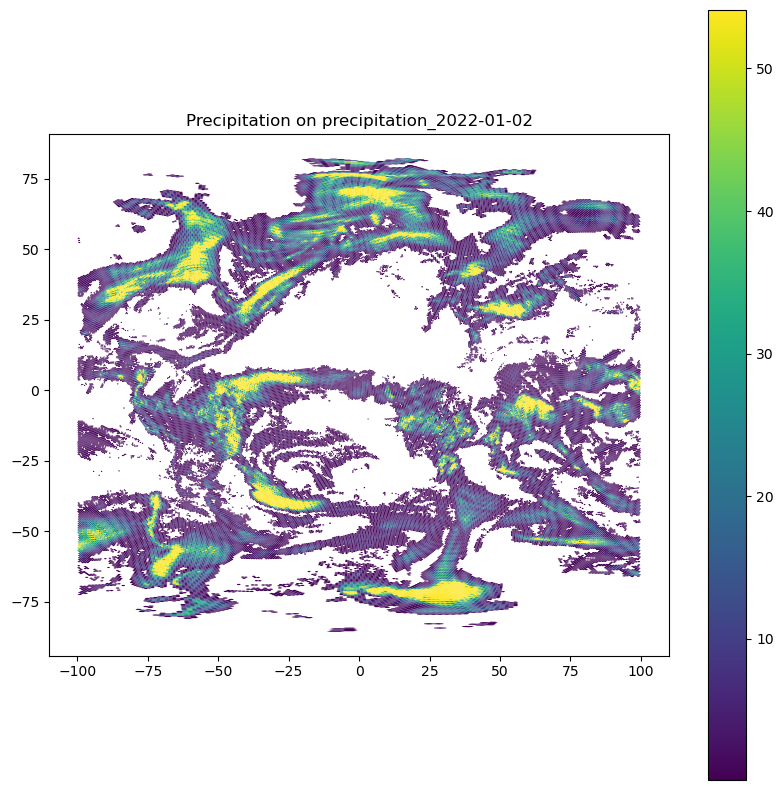

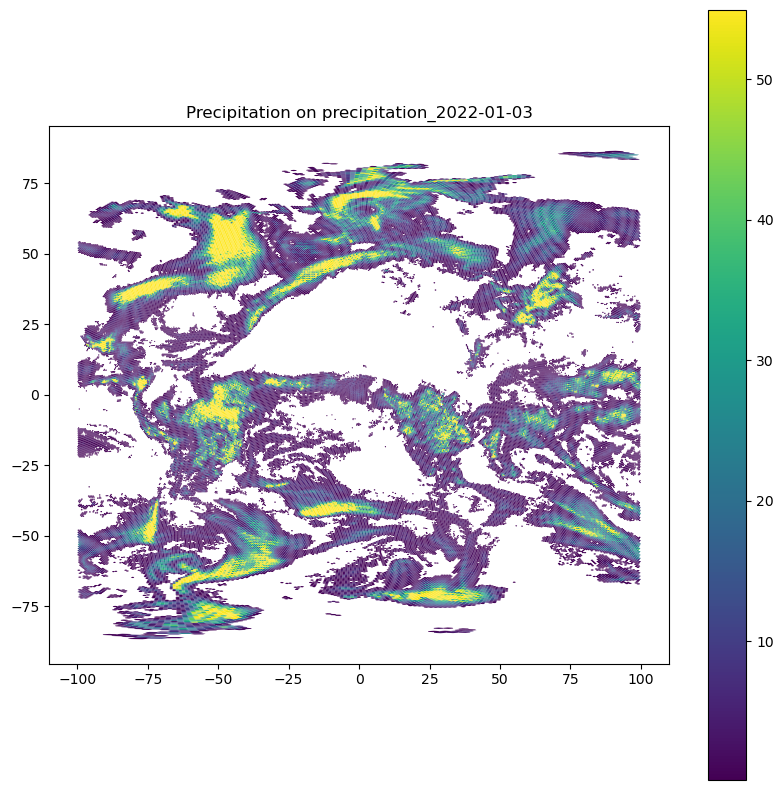

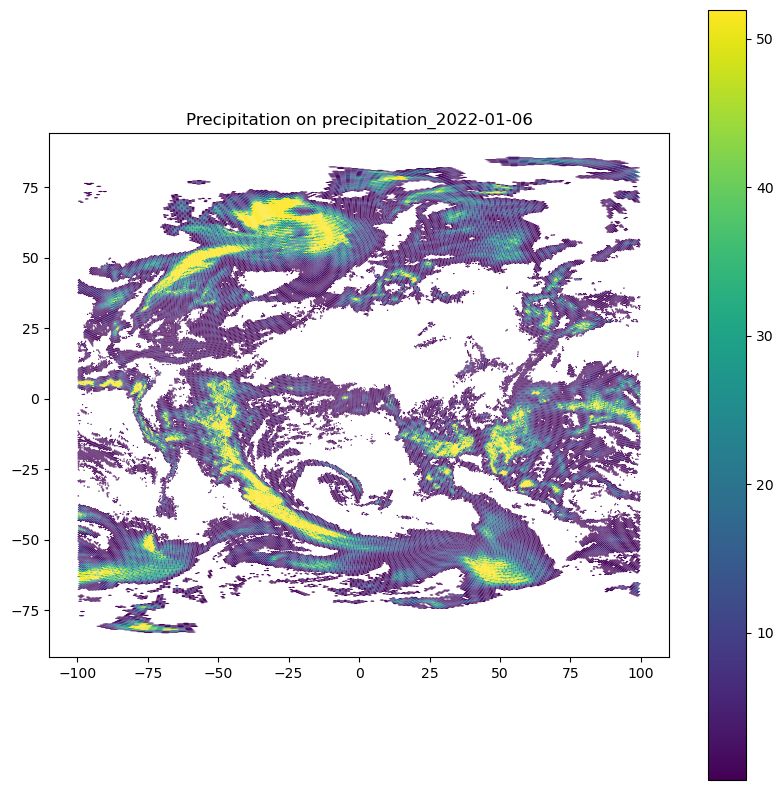

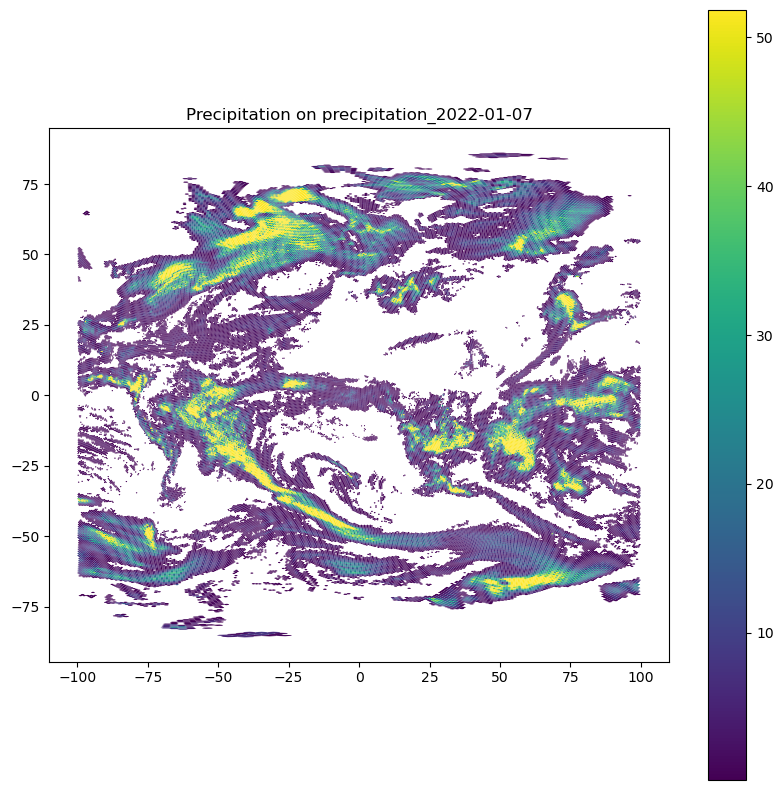

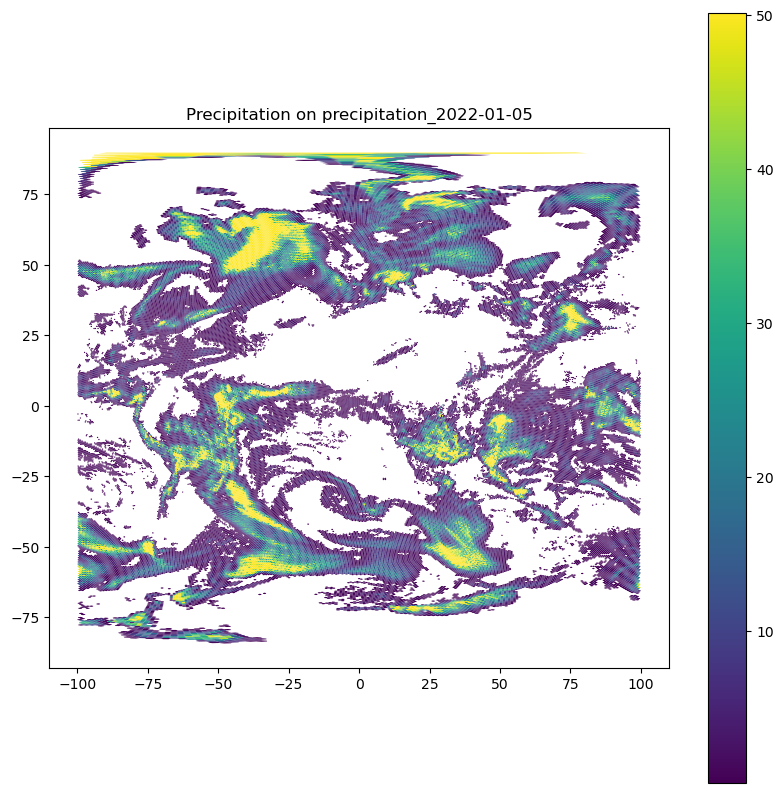

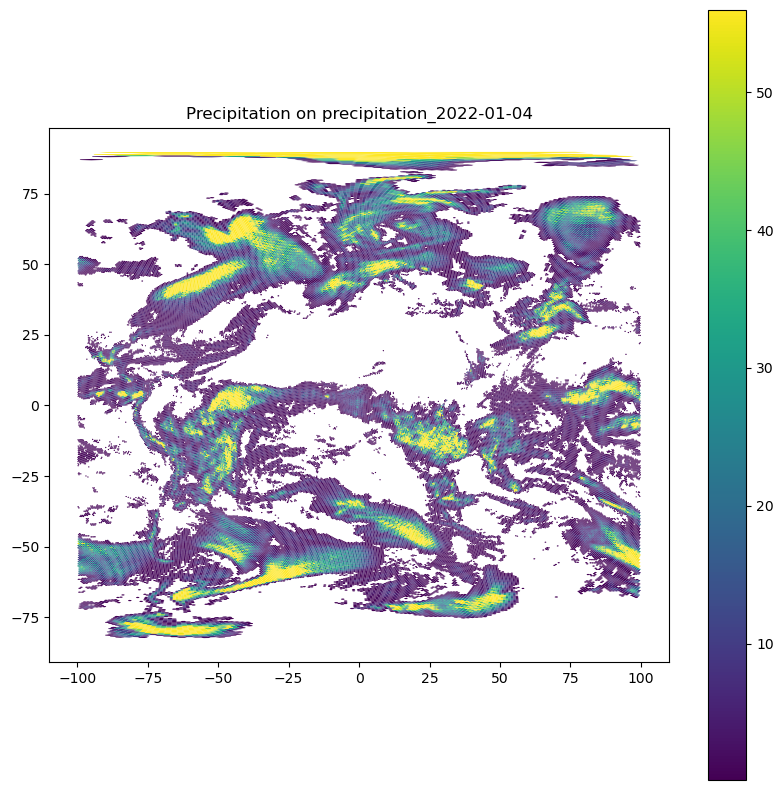

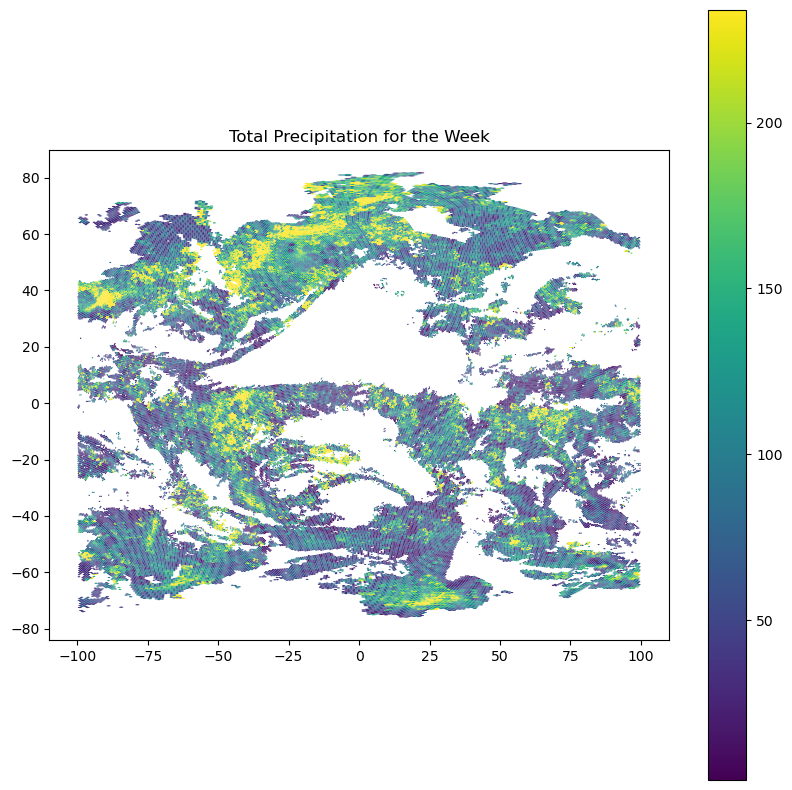

In [1]:
import os
import pandas as pd
import h3
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt

# Create the visuals directory if it doesn't exist
visuals_directory = 'data/visuals'
os.makedirs(visuals_directory, exist_ok=True)

# Function to convert H3 index to polygon
def h3_to_polygon(h3_index):
    h3_index_str = h3.h3_to_string(h3_index)  # Convert integer H3 index to string
    boundary = h3.h3_to_geo_boundary(h3_index_str, geo_json=True)  # Get hexagon boundary
    return Polygon(boundary)

# Function to plot precipitation data
def plot_precipitation(gdf, title, output_file=None):
    fig, ax = plt.subplots(figsize=(10, 10))

    vmin = gdf['precipitation'].min()
    vmax = gdf['precipitation'].quantile(0.95)  # Set the contrast

    # Plot the filtered hexagons with color mapped to precipitation
    gdf.plot(column='precipitation', ax=ax, legend=True, cmap='viridis', edgecolor=None, linewidth=0, vmin=vmin, vmax=vmax)

    plt.title(title)
    if output_file:
        plt.savefig(output_file)
    plt.show()

# Directory containing the Parquet files
parquet_directory = 'data/processed'

# List all parquet files in the directory
parquet_files = [os.path.join(parquet_directory, f) for f in os.listdir(parquet_directory) if f.endswith('.parquet')]

# Variable to accumulate data for the entire week
df_week = None

# Iterate through each parquet file and create daily plots
for parquet_file in parquet_files:
    # Extract day from the filename (assuming format is '2022-01-01.parquet')
    day = os.path.basename(parquet_file).split('.')[0]

    # Read parquet file into a DataFrame
    df = pd.read_parquet(parquet_file)

    # Group by H3 index and aggregate precipitation by summing for the day
    df_agg = df.groupby('h3_index', as_index=False)['precipitation'].sum()

    # Convert the H3 indexes to polygons
    df_agg['geometry'] = df_agg['h3_index'].apply(lambda x: h3_to_polygon(x))

    # Convert to GeoDataFrame for spatial visualization
    gdf = gpd.GeoDataFrame(df_agg, geometry='geometry')
    gdf = gdf.set_crs(epsg=4326)

    # Filter for a specific region (example: longitudes between -100 and 100)
    gdf_filtered = gdf[(gdf['geometry'].bounds.minx > -100) & (gdf['geometry'].bounds.maxx < 100)]

    # Plot for the day and save to the visuals folder
    output_path = os.path.join(visuals_directory, f"{day}.png")
    plot_precipitation(gdf_filtered, f"Precipitation on {day}", output_file=output_path)

    # Accumulate the weekly data by summing precipitation across days
    if df_week is None:
        df_week = df_agg.copy()  # Initialize with the first day's data
    else:
        df_week['precipitation'] += df_agg['precipitation']  # Sum precipitation values

# After processing all days, plot the weekly total
df_week['geometry'] = df_week['h3_index'].apply(lambda x: h3_to_polygon(x))
gdf_week = gpd.GeoDataFrame(df_week, geometry='geometry')
gdf_week = gdf_week.set_crs(epsg=4326)

# Filter the weekly total for the same region
gdf_week_filtered = gdf_week[(gdf_week['geometry'].bounds.minx > -100) & (gdf_week['geometry'].bounds.maxx < 100)]

# Plot the weekly total precipitation and save to the visuals folder
weekly_output_path = os.path.join(visuals_directory, "weekly_precipitation.png")
plot_precipitation(gdf_week_filtered, "Total Precipitation for the Week", output_file=weekly_output_path)
